# Reddit Data Pre-Processing

In [11]:
import json
import os
import sys
import numpy as np
import pandas as pd
from pprint import pprint

In [ ]:
# Put all directory information in this cell.
print("You are currently in", os.getcwd(), "\n")

DATA_DIR = '/home/brandon/Downloads/2007/'
DATA_FILES = os.listdir(DATA_DIR)
DATA_FILES = [DATA_DIR + DATA_FILE for DATA_FILE in DATA_FILES]
print("Contents of {}:".format(DATA_DIR))
print(DATA_FILES, "\n")

raw_data = np.array([
    [json.loads(json_dict) for json_dict in open(data_file)] 
    for data_file in DATA_FILES
])
print(raw_data.shape)

In [40]:
keys_to_remove = [k for k in raw_data[0][0] if k not in ['author', 'body']]
def remove_items_with_keys(dictionary, unwanted_keys):
    for k in unwanted_keys:
        dictionary.pop(k, None)
    

In [42]:
# Get comments and remove unwanted information.
comments_only = list(raw_data[0])
for d in comments_only[:4]: 
    remove_items_with_keys(d, keys_to_remove)
comments_only = [item['body'] for item in comments_only]
print("Example entries of reddit comments:")
for comment in comments_only[:4]: print(comment)

Example entries of reddit comments:
test
much smoother.

Im just glad reddit is back, #reddit in mIRC was entertaining but I had no idea how addicted I had become. Thanks for making the detox somewhat short.
Can we please deprecate the word "Ajax" now? 

(But yeah, this _is_ much nicer)
[deleted]


In [45]:
??nltk.sent_tokenize

In [50]:
import itertools
import nltk

vocabulary_size = 4000
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

print("[BEGINNING] TOKENIZING COMMENTS . . . ")
sentences = itertools.chain(*[nltk.sent_tokenize(comment) for comment in comments_only])
print("[DONE] TOKENIZING COMMENTS . . . ")

sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
print( "Parsed %d sentences." % (len(sentences)))

[BEGINNING] TOKENIZING COMMENTS . . . 
[DONE] TOKENIZING COMMENTS . . . 
['SENTENCE_START test SENTENCE_END', 'SENTENCE_START much smoother. SENTENCE_END', 'SENTENCE_START Im just glad reddit is back, #reddit in mIRC was entertaining but I had no idea how addicted I had become. SENTENCE_END', 'SENTENCE_START Thanks for making the detox somewhat short. SENTENCE_END', 'SENTENCE_START Can we please deprecate the word "Ajax" now? SENTENCE_END', 'SENTENCE_START (But yeah, this _is_ much nicer) SENTENCE_END', 'SENTENCE_START [deleted] SENTENCE_END', 'SENTENCE_START Oh, I see. SENTENCE_END', 'SENTENCE_START Fancy schmancy "submitting...." SENTENCE_END', 'SENTENCE_START testing ... SENTENCE_END']


In [52]:
# Tokenize the sentences into words
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
 
# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Found 146867 unique words tokens.


In [ ]:
# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])
 

In [56]:
print( "Using vocabulary size %d." % vocabulary_size)
print( "Least frequent word in vocab: '%s', which appeared %d times." % (vocab[-1][0], vocab[-1][1]))
print( "Most frequent word in vocab: '%s', which appeared %d times." % (vocab[0][0], vocab[0][1])) 
print("Top 10 freq words and frequencies:")
for word, freq in vocab[:10]:
    print(word, "\t", freq)

Using vocabulary size 4000.
Least frequent word in vocab: 'breasts', which appeared 97 times.
Most frequent word in vocab: 'SENTENCE_START', which appeared 391452 times.
Top 10 freq words and frequencies:
SENTENCE_START 	 391452
SENTENCE_END 	 391452
. 	 279683
, 	 206150
the 	 198631
to 	 132886
a 	 110935
of 	 99477
I 	 94112
and 	 89096


In [55]:
# Replace all words not in our vocabulary with the unknown token
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

print("\nExample sentence: '%s'" % sentences[0])
print( "\nExample sentence after Pre-processing: '%s'" % tokenized_sentences[0])
 
# Create the training data
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])
print("ayy")


Example sentence: 'SENTENCE_START test SENTENCE_END'

Example sentence after Pre-processing: '['SENTENCE_START', 'test', 'SENTENCE_END']'
ayy


### Read in data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

data_path = "/Users/ivan/Documents/sp_17/reddit_data/2007/RC_2007-10.json"
df = pd.read_json(data_path, lines=True)

In [2]:
## Returns a list of length equal to the number of rows in our data frame. 
def root_comments(df):
    root_value = []
    for row in df.itertuples():
        root_value.append(row.parent_id == row.link_id)
    return root_value

### Initial Clean up

1. Start by removing comments without a body (deleted).
2. Remove comments larger than 150 characters long.
3. Remove unneccesary columns. 
4. Add a column determining whether a row is a root comment.
5. Add a column determining the size of the body in characters.

In [3]:
df = df.assign(root=pd.Series(root_comments(df)))
df = df[['author', 'body', 'link_id', 'parent_id', 'name', 'root', 'subreddit']]
df = df.loc[df.body != '[deleted]']
sizes = [len(a) for a in df.body.values]
df = df.assign(body_len = pd.Series(sizes).values)
df = df.loc[df.body_len < 150]

In [4]:
## Returns a dictionary with keys being the root comments and values being their immediate children.
## Assumes to have a 'root' column already

## Go through all comments, if it is a root skip it since they wont have a parent_id corresponding
## to a comment.
## 
def children_dict(df):
    children = {}
    for row in df.itertuples():
        if row.root == False:
            if row.parent_id in children.keys():
                children[row.parent_id].append(row.name)
            else:
                children[row.parent_id] = [row.name]
    return children

In [5]:
## Return a dictionary with name being the key and body being the value. 
values_dict = pd.Series(df.body.values, index=df.name).to_dict()
children = children_dict(df)

In [6]:
## Generates two files, [from_file_path] and [to_file_path] of one-to-one comments. 
def generate_files(from_file_path, to_file_path):
    ## Open the files and clear them. 
    from_file = open(from_file_path, 'w')
    to_file = open(to_file_path, 'w')
    from_file.write("")
    to_file.write("")
    from_file.close()
    to_file.close()

    for key in children.keys():
        from_file = open(from_file_path, 'a')
        to_file = open(to_file_path, 'a')

        ## Since we have deleted comments, some comments parents might not exist anymore so we must catch that error.
        for child in children[key]:
            try: 
                from_file.write(values_dict[key].replace('\n', '').replace('\r', ' ').replace('&gt', '') + "\n")
                to_file.write(values_dict[child].replace('\n', '').replace('\r', ' ').replace('&gt', '') + "\n")
            except KeyError:    
                pass
    from_file.close()
    to_file.close()

In [7]:
generate_files('from_file.txt', 'to_file.txt')

### Working with NLTK

In [8]:
import nltk
f = open('from_file.txt','r')
raw_text = f.read()
tokens = nltk.word_tokenize(raw_text)


In [11]:
len(tokens)

346108

In [59]:
## take a list of tokens and convert it into a dictionary whose keys are the words and values are the word count
def create_word_dictionary(tokens):
    word_dictionary = {}
    for word in tokens:
        if word in word_dictionary.keys():
            word_dictionary[word] += 1
        else: 
            word_dictionary[word] = 1
    return word_dictionary

def clean_word_dictinoary(word_dict):
    return {key: value for key, value in word_dict.items()
            if value < 300}

In [60]:
dictionary = create_word_dictionary(tokens)

In [61]:
values = dictionary.values()

In [62]:
values = list(values)

In [63]:
np.mean(values)

12.80885237407942

In [64]:
clean_dict = clean_word_dictinoary(dictionary)

In [65]:
len(clean_dict)

26881

### A histogram of frequency of word occurence for words which occur less than 300 times in our dictionary

(0, 100)

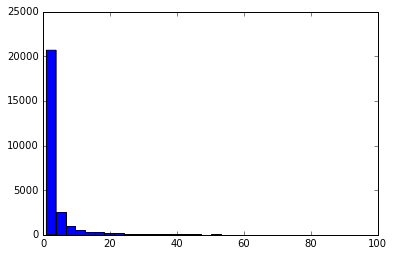

In [69]:
plt.hist(list(clean_dict.values()), bins = 100)
plt.xlim(0, 100)

### Removing Links
1. The format for links is "[link description] (link.link)"

In [90]:
def contains_link(dictionary):
    """ Determines if the comment contains a link.
    Returns a list of Booleans indicating this.
    """
    return {key: value for key, value in dictionary.items() 
           if fnmatch.fnmatch(value, "*[ * ]*") }

In [76]:
sample = "This is a test[at](ata)"
import re
import fnmatch

In [91]:
link_dict = contains_link(values_dict)

In [93]:
values_dict

{'t1_c02az44': 'Adrian Edmonson has a lot to answer for.',
 't1_c02b3e1': " Oh come on, we're talking *China*. Can't really find China's grotesquery in *Das Kapital* or *The Communist Manifesto* ",
 't1_c029ht7': '&gt; how long would it take for a space ship to arive there?\n\nKinda depends on how fast the space ship is traveling.',
 't1_c029af8': 'He is? I thought for sure it was Saddaam H. based on all the spin. :-/',
 't1_c02bbai': "No, the boys at the lab dusted for sarcasm and came up empty.  There's nothing there.",
 't1_c02cfdi': "No, it's multiple accounts. Trust me.\n\nI find it ironic that a right-winger immediately tries to game a voting system when nobody agrees with him.",
 't1_c02a3an': "The countries of the world are interested in global stability, that's what the UN is for.",
 't1_c02acr1': 'What a wonderful world.',
 't1_c029btx': 'All kinds of things. In Haskell, lists are monads, so are continuations, and logging, and many other uses.',
 't1_c02ah6l': 'Worrisome.  Th